<a href="https://colab.research.google.com/github/rahulvenkat207/calculas/blob/main/sinApprox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd


In [135]:
def generate_angle_grid(num_points):
    return np.linspace(0, np.pi/2, num_points)

In [136]:
def compute_sine_values(angles):
    return np.sin(angles)

In [137]:
def calculate_slope(x1, x2, y1, y2):
    return (y2 - y1) / (x2 - x1)

In [138]:
def find_error_point(x1, x2, line_slope):
    def equation(x):
        return np.cos(x) - line_slope
    return opt.root_scalar(equation, bracket=[x1, x2]).root

In [139]:
def evaluate_interpolation_error(angles, sine_values):
    errors = []
    max_error = 0
    for i in range(len(angles) - 1):
        x1, x2 = angles[i], angles[i + 1]
        y1, y2 = sine_values[i], sine_values[i + 1]

        line_slope = calculate_slope(x1, x2, y1, y2)  # Slope of the line

        critical_angle = find_error_point(x1, x2, line_slope)  # Find error point

        interpolated_value = y1 + (y2 - y1) / (x2 - x1) * (critical_angle - x1)
        actual_value = np.sin(critical_angle)

        error = np.abs(actual_value - interpolated_value)
        if error > max_error:
            max_error = error

        errors.append(error)
    errors.append(0)

    return max_error, np.array(errors)

In [140]:
def sine_interpolation_process(tolerance, max_iterations=100):
    num_points = 10
    angles = generate_angle_grid(num_points)
    sine_values = compute_sine_values(angles)

    for iteration in range(max_iterations):
        angles = generate_angle_grid(num_points)
        sine_values = compute_sine_values(angles)
        max_error, errors = evaluate_interpolation_error(angles, sine_values)

        error_ratio = max_error / tolerance

        if error_ratio > 1:
            num_points = int(num_points * (1 + error_ratio))
        elif error_ratio < 0.5:
            num_points = max(10, int(num_points * (0.5 + error_ratio)))
        else:
            break

    return angles, sine_values, num_points

In [141]:
def adjust_angles_and_sines(angles, sine_values, tolerance):
    refined_angles = np.copy(angles)
    refined_sine = np.copy(sine_values)

    i = 1
    while i < len(refined_angles) - 1:
        temp_angles = np.delete(refined_angles, i)
        temp_sine = np.sin(temp_angles)

        max_error, errors = evaluate_interpolation_error(temp_angles, temp_sine)

        if max_error <= tolerance:
            refined_angles = temp_angles
            refined_sine = temp_sine
        else:
            i += 1

    return refined_angles, refined_sine

In [142]:
tolerance = 0.001
final_angles, final_sine, final_num_points = sine_interpolation_process(tolerance)
new_angles = generate_angle_grid(final_num_points)
new_sine = compute_sine_values(new_angles)


In [143]:
refined_angles, refined_sine = adjust_angles_and_sines(new_angles, new_sine, tolerance)


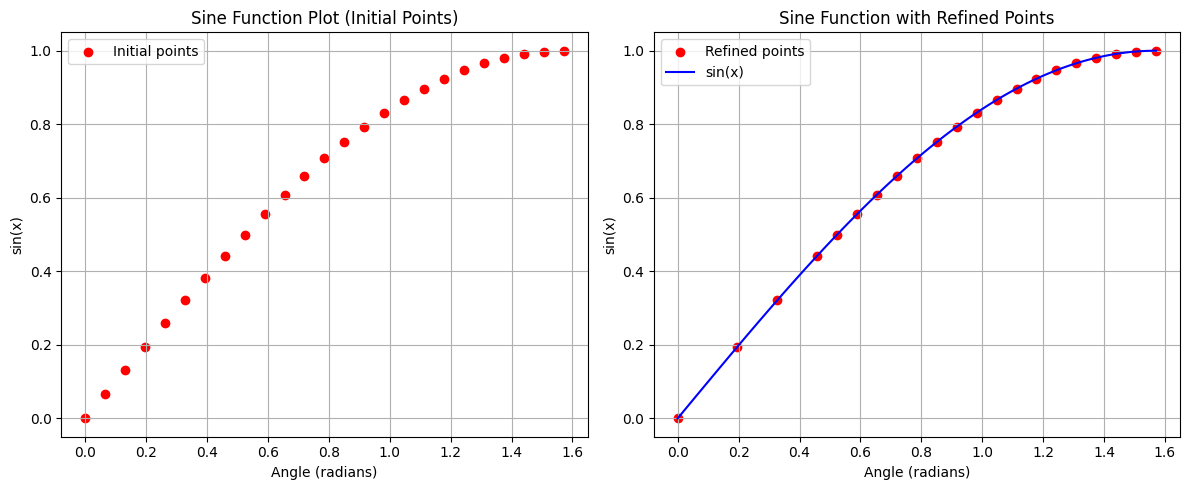

In [144]:
# Plotting two graphs side by side
plt.figure(figsize=(12, 5))

# Plot 1: Initial Points
plt.subplot(1, 2, 1)
plt.scatter(final_angles, final_sine, color='red', label='Initial points')
plt.title('Sine Function Plot (Initial Points)')
plt.xlabel('Angle (radians)')
plt.ylabel('sin(x)')
plt.grid(True)
plt.legend()

# Plot 2: Refined Points and Sine Wave
plt.subplot(1, 2, 2)
plt.scatter(refined_angles, refined_sine, color='red', label='Refined points')
angles = np.linspace(0, np.pi / 2, 100)
sin_values = np.sin(angles)
plt.plot(angles, sin_values, color='blue', label='sin(x)')
plt.title('Sine Function with Refined Points')
plt.xlabel('Angle (radians)')
plt.ylabel('sin(x)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [145]:
def generate_lookup_table(angles, sine_values):
    return np.column_stack((angles, sine_values))

def interpolate_sine_value(x, x0, y0, x1, y1):
    return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


In [146]:
def predict_sine_value(angle_degrees):
    negative = False
    if angle_degrees < 0:
        angle_degrees = abs(angle_degrees)
        negative = True

    angle_degrees = angle_degrees % 360

    if 0 <= angle_degrees <= 90:
        sine_value = lookup_sine_from_table(angle_degrees)
    elif 90 < angle_degrees <= 180:
        sine_value = lookup_sine_from_table(180 - angle_degrees)
    elif 180 < angle_degrees <= 270:
        sine_value = -lookup_sine_from_table(angle_degrees - 180)
    elif 270 < angle_degrees < 360:
        sine_value = -lookup_sine_from_table(360 - angle_degrees)

    if negative:
        sine_value = -sine_value

    return sine_value

In [147]:
def lookup_sine_from_table(angle_degrees):
    angle_radians = np.radians(angle_degrees)

    for i in range(len(refined_table) - 1):
        if refined_table[i, 0] <= angle_radians <= refined_table[i + 1, 0]:
            x1, y1 = refined_table[i]
            x2, y2 = refined_table[i + 1]

            return interpolate_sine_value(angle_radians, x1, y1, x2, y2)

# Create lookup tables
refined_table = generate_lookup_table(refined_angles, refined_sine)
initial_table = generate_lookup_table(final_angles, final_sine)





In [148]:
# Generate 100 random angles and predict sine values
angles = np.random.uniform(-360, 360, 100)

In [149]:
predicted_sines = np.array([predict_sine_value(angle) for angle in angles])
actual_sines = np.sin(np.radians(angles))

# Calculate errors and create DataFrame
errors = np.abs(predicted_sines - actual_sines)
data = {
    "Angle (degrees)": angles,
    "Predicted sine": predicted_sines,
    "Actual sine": actual_sines,
    "Error": errors,
    "Within Tolerance": errors <= tolerance
}
df = pd.DataFrame(data)


In [150]:
df.head(10
        )

,Angle (degrees),Predicted sine,Actual sine,Error,Within Tolerance
0,80.019078,0.984393,0.984866,4.728144e-04,True
1,320.935620,-0.629864,-0.630193,3.296120e-04,True
2,322.909762,-0.602949,-0.603072,1.228532e-04,True
3,340.983390,-0.325735,-0.325842,1.068324e-04,True
4,-109.964166,-0.939467,-0.939906,4.394812e-04,True
5,-129.213727,-0.774382,-0.774793,4.111336e-04,True
6,-123.081076,-0.837634,-0.837899,2.653756e-04,True
7,-323.747420,0.591068,0.591346,2.783357e-04,True
8,-298.390169,0.879268,0.879730,4.623652e-04,True
9,82.500182,0.991445,0.991445,1.033630e-07,True


In [151]:
# Calculate sine values using the predict_sine_value function
predicted_cos = np.array([predict_sine_value(90 + angle) for angle in angles])

# Calculate actual sine values for comparison
actual_cos = np.sin(np.radians(90 + angles))

# Calculate errors
sine_errors = np.abs(predicted_cos - actual_cos)
sine_data = {
    "Original Angle (degrees)": angles,
    "Predicted Sine (90 + angle)": predicted_cos,
    "Actual Sine (90 + angle)": actual_cos,
    "Error": sine_errors,
    "Within Tolerance": sine_errors <= tolerance
}

cosine_df = pd.DataFrame(sine_data)



In [152]:
cosine_df.head(10)

,Original Angle (degrees),Predicted Sine (90 + angle),Actual Sine (90 + angle),Error,Within Tolerance
0,80.019078,0.173083,0.173320,0.000237,True
1,320.935620,0.776035,0.776438,0.000403,True
2,322.909762,0.797518,0.797687,0.000168,True
3,340.983390,0.945291,0.945424,0.000133,True
4,-109.964166,-0.341004,-0.341432,0.000429,True
5,-129.213727,-0.631878,-0.632215,0.000337,True
6,-123.081076,-0.545658,-0.545825,0.000168,True
7,-323.747420,0.806033,0.806418,0.000385,True
8,-298.390169,0.475225,0.475473,0.000248,True
9,82.500182,0.130057,0.130523,0.000466,True


In [155]:
# Calculate tangent as the ratio of sin(X) / sin(90 + X)
predicted_tan = predicted_sines / predicted_cos
actual_tan = np.tan(np.radians(angles))

# Calculate tangent errors
tan_errors = np.abs(predicted_tan - actual_tan)

# Create DataFrame for tangent results
tan_data = {
    "Angle (degrees)": angles,
    "Predicted tan": predicted_tan,
    "Actual tan": actual_tan,
    "Tan Error": tan_errors,
    "Within Tolerance": tan_errors <= tolerance
}
tan_df = pd.DataFrame(tan_data)

In [156]:
tan_df.head(10)

,Angle (degrees),Predicted tan,Actual tan,Tan Error,Within Tolerance
0,80.019078,5.687410,5.682345,0.005065,False
1,320.935620,-0.811643,-0.811646,0.000003,True
2,322.909762,-0.756032,-0.756026,0.000006,True
3,340.983390,-0.344587,-0.344652,0.000065,True
4,-109.964166,2.755006,2.752833,0.002173,False
5,-129.213727,1.225524,1.225522,0.000002,True
6,-123.081076,1.535090,1.535105,0.000015,True
7,-323.747420,0.733305,0.733300,0.000005,True
8,-298.390169,1.850213,1.850220,0.000007,True
9,82.500182,7.623156,7.595941,0.027215,False
